Note:
1. "AAAA"-dict, "AaAa"-array, "Aaaa"-df, "aa_aa"-list, "aaaa"-single value.  
2. Stage - ID: Rest1 - 1, Cool Test - 2, Recover - 3, Rest2 - 4.
3. SIG array shape: ECG, CBP, PPG, IPG, Temp, Stage, ECGf, 

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import scipy.io
import os

### Read the signal data

In [2]:
data_root = 'C:\COCHE_Project\MMBP\data\MMData'
## The list of subject number.
sub_id = list(os.walk(data_root))[0][1]

In [3]:
def combine_row_signals(subid): ## Input "ID", Return EntireStage.
    ## Find signal segments in each stage.
    rest1_s = []
    CT_s = []
    recover_s = []
    rest2_s = []
    seg_signal_name = [n.split('.')[0] for n in list(os.walk(f"{data_root}\{subid}"))[0][2]]
    for segsig in seg_signal_name:
        SegSignal = scipy.io.loadmat(f"{data_root}\{subid}\{segsig}.mat")[segsig]
        for stage in segsig.split('_'):
            if stage in ['recover', 're', 'Recover']: #this seg is one of Recover
                recover_s.append(SegSignal)
            elif stage in ['rest1']:
                rest1_s.append(SegSignal)
            elif stage in ['CT', 'ct', 'ct1', 'ct2']: ##
                CT_s.append(SegSignal)
            elif stage in ['rest2']:
                rest2_s.append(SegSignal)
            elif stage in ['rest']:
                rest_index = segsig.split('_').index('rest')
                if segsig.split('_')[rest_index + 1] == '1':
                    rest1_s.append(SegSignal)
                else:
                    rest2_s.append(SegSignal)

    ## Concat each stage to one signal, and add Stage Tag under each signal array.  
    stageid = 0
    entire_stage = []
    for stage_list in [rest1_s, CT_s, recover_s, rest2_s]:       
        stageid += 1
        StageSig = np.concatenate(stage_list, axis=1)
        StageCom = np.concatenate((StageSig, np.full((1, StageSig.shape[1]), stageid)), axis=0)      
        entire_stage.append(StageCom)
    EntireStage = np.concatenate(entire_stage, axis=1)

    return EntireStage

In [4]:
SIG = {subid:combine_row_signals(subid) for subid in sub_id}

Show signals and save

### Process signals

In [207]:
fs = 2000
result_root = 'C:\COCHE_Project\MMBP\Result\Result_12Dec23'
subid = '1'

Filter signals

In [192]:
def filter_ecg(Sig, lowcut=10.0, highcut=50.0, order=4, figshow=0):
    b,a = signal.butter(order, [lowcut, highcut], btype='band', fs=fs)
    ecg_filtered = signal.filtfilt(b, a, Sig)

    if figshow == 1 :
        IntervalIndex = np.append(np.arange(0, len(Sig), 60*fs), len(Sig))
        for interind in range(len(IntervalIndex) - 1):
            begin_index = IntervalIndex[interind]
            end_index = IntervalIndex[interind + 1]
            fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(18,4),dpi=96)
            axs[0].plot(Sig[begin_index:end_index])
            axs[0].set_title('Original ECG')
            axs[1].plot(ecg_filtered[begin_index:end_index])
            axs[1].set_title('Filtered ECG')
            fig.subplots_adjust(hspace=0.55)
            fig.suptitle(f"S{subid} {int(begin_index/fs)} to {int(end_index/fs)} sec", fontsize=16)
            result_path = result_root + f"\S{subid}\ECG"
            if not os.path.exists(result_path):
                os.makedirs(result_path)
            plt.savefig(f"{result_path}\S{subid}_Ori&Fil_ECG_{int(begin_index/fs)}to{int(end_index/fs)}sec.png")
            plt.show()

    return ecg_filtered


In [208]:
## Add ECGf to the end of SIG array
SIG[subid] = combine_row_signals(subid)
print(SIG[subid].shape)
SIG[subid] = np.concatenate((SIG[subid], filter_ecg(SIG[subid][0], figshow=0).reshape(1, -1)), axis=0)
SIG[subid].shape

(6, 888006)


(7, 888006)

Find keypoints

In [246]:
def find_Rpeak(Sig, r_height=0.5, beat=100, figshow=0):
    ## Find peaks once in a window length, one by one.
    rpeak_index = []
    rpeak_value = []
    IntervalIndex = np.append(np.arange(0, len(Sig), 100000), len(Sig))
    for interind in range(len(IntervalIndex) - 1):
        begin_index = IntervalIndex[interind]
        end_index = IntervalIndex[interind + 1]
        SigSeg = Sig[begin_index: end_index]
        height = r_height * np.max(SigSeg)
        distance = 60 / beat * fs
        rpeak_index_seg, rpeak_value_fil = signal.find_peaks(SigSeg, height=height, distance=distance)
        rpeak_index.append(rpeak_index_seg)
        rpeak_value.append(rpeak_value_fil['peak_heights'])

        if figshow == 1:
            plt.figure(figsize=(18,3),dpi=96)
            plt.plot(SigSeg)
            plt.scatter(rpeak_index_seg, rpeak_value_fil['peak_heights'])
            plt.title(f"S{subid} R-peak from {int(begin_index/fs)} to {int(end_index/fs)} sec")
            result_path = result_root + f"\S{subid}\Rpeak"
            if not os.path.exists(result_path):
                os.makedirs(result_path)
            plt.savefig(f"{result_path}\S{subid}_Rpeak_{int(begin_index/fs)}to{int(end_index/fs)}sec.png")
            plt.show()

    #print(rpeak_value, rpeak_index)
    RpeakIndex = np.concatenate(rpeak_index).reshape(1, -1)
    RpeakValue = np.concatenate(rpeak_value).reshape(1, -1)
    return np.concatenate((RpeakIndex, RpeakValue), axis=0)

def find_keypoints(subid, r_height=0.5, beat=100, figshow=0):
    print(f"Subject {subid}")
    ECGSig = SIG[subid][6]
    CBPSig = SIG[subid][1]
    PPGSig = SIG[subid][2]
    IPGSig = SIG[subid][3]

    ## Find R peaks
    rpeak_index = []
    rpeak_value = []
    RIntervalIndex = np.append(np.arange(0, len(ECGSig), 5*fs), len(ECGSig))
    for interind in range(len(RIntervalIndex) - 1):
        begin_index = RIntervalIndex[interind]
        end_index = RIntervalIndex[interind + 1]
        ECGSeg = ECGSig[begin_index: end_index]
        height = r_height * np.max(ECGSeg)
        distance = 60 / beat * fs
        RpeakIndexSeg, rpeak_value_fil = signal.find_peaks(ECGSeg, height=height, distance=distance)
        rpeak_index.append(RpeakIndexSeg + begin_index)
        rpeak_value.append(rpeak_value_fil['peak_heights'])
    RpeakIndex = np.concatenate(rpeak_index)
    RpeakValue = np.concatenate(rpeak_value)
    #print(RpeakIndex)

    ## Find keypoints in other signals
    sbp_index = []
    dbp_index = []
    maxppg_index = []
    minppg_index = []
    highipg_index = []
    lowipg_index = []
    ipg_area = []
    SigSegIndex = np.append(RpeakIndex, len(ECGSig))
    #print(SigSegIndex.shape)
    for segint in range(len(SigSegIndex) - 1):
        begin_index = SigSegIndex[segint]
        end_index = SigSegIndex[segint + 1]
        
        ## Find SBP and DBP
        CBPSeg = CBPSig[begin_index: end_index]
        #print(CBPSeg)
        sbp_i, _ = signal.find_peaks(CBPSeg)
        if len(sbp_i) > 0:
            SbpV = CBPSeg[sbp_i]
            sbp_index.append(sbp_i[np.argmax(SbpV)] + begin_index)
            ## DBP between R peak and SBP
            HCBPSeg = CBPSig[begin_index: sbp_index[-1]]
            dbp_i, _ = signal.find_peaks(-HCBPSeg)
            if len(dbp_i) > 0:
                DbpV = HCBPSeg[dbp_i]
                dbp_index.append(dbp_i[np.argmin(DbpV)] + begin_index)
            else:
                dbp_index.append(sbp_index[-1])
        else:
            sbp_index.append(begin_index)
            dbp_index.append(begin_index)

        ## Find MaxPPG and MinPPG
        PPGSeg = PPGSig[begin_index: end_index]
        maxppg_i, _ = signal.find_peaks(PPGSeg)
        if len(maxppg_i) > 0:
            MaxppgV = PPGSeg[maxppg_i]
            maxppg_index.append(maxppg_i[np.argmax(MaxppgV)] + begin_index)
            ## MinPPG between R peak and MaxPPG
            HPPGSeg = PPGSig[begin_index: maxppg_index[-1]]
            minppg_i, _ = signal.find_peaks(-HPPGSeg)
            if len(minppg_i) > 0:
                MinppgV = HPPGSeg[minppg_i]
                minppg_index.append(minppg_i[np.argmin(MinppgV)] + begin_index)
            else:
                minppg_index.append(maxppg_index[-1])
        else:
            maxppg_index.append(begin_index)
            minppg_index.append(begin_index)

        ## Find LowIPG, HighIPG, and IPG area.
        IPGSeg = IPGSig[begin_index: end_index]
        if np.argmin(IPGSeg) > 0:
            lowipg_index.append(np.argmin(IPGSeg) + begin_index)
            HIPGSeg = IPGSig[begin_index: lowipg_index[-1]]
            highipg_i, _ = signal.find_peaks(HIPGSeg)
            if len(highipg_i) > 0:
                HighipgV = HIPGSeg[highipg_i]
                highipg_index.append(highipg_i[np.argmax(HighipgV)] + begin_index)
            else:
                highipg_index.append(np.argmax(HIPGSeg) + begin_index)
        else:
            lowipg_index.append(begin_index)
            highipg_index.append(begin_index)
        XV = np.arange(len(IPGSeg))
        area = np.trapz(IPGSeg, XV)
        ipg_area.append(area / fs)

    '''print(f"SBP index: {len(sbp_index)}, {sbp_index}\nDBP index: {len(dbp_index)}, {dbp_index}")
    print(f"Max PPG index: {len(maxppg_index)}, {maxppg_index}\nMin PPG index: {len(minppg_index)}, {minppg_index}")
    print(f"High IPG index: {len(highipg_index)}, {highipg_index}\nLow IPG index: {len(lowipg_index)}, {lowipg_index}")
    print(f"IPG_area: {len(ipg_area)}, {ipg_area}")'''

    SBPIndex = np.array(sbp_index)
    SBPValue = CBPSig[SBPIndex]
    DBPIndex = np.array(dbp_index)
    DBPValue = CBPSig[DBPIndex]
    MaxPPGIndex = np.array(maxppg_index)
    MaxPPGValue = PPGSig[MaxPPGIndex]
    MinPPGIndex = np.array(minppg_index)
    MinPPGValue = PPGSig[MinPPGIndex]
    HighIPGIndex = np.array(highipg_index)
    HighIPGValue = IPGSig[HighIPGIndex]
    LowIPGIndex = np.array(lowipg_index)
    LowIPGValue = IPGSig[LowIPGIndex]
    IPGArea = np.array(ipg_area)

    Keypoints = pd.DataFrame({
        'RpeakI': RpeakIndex, 'RpeakV': RpeakValue, 
        'SBPI': SBPIndex, 'SBPV': SBPValue, 'DBPI': DBPIndex, 'DBPV': DBPValue,
        'MaxPPGI': MaxPPGIndex, 'MaxPPGV': MaxPPGValue, 'MinPPGI': MinPPGIndex, 'MinPPGV': MinPPGValue, 
        'HighIPGI': HighIPGIndex, 'HighIPGV': HighIPGValue, 'LowIPGI': LowIPGIndex, 'LowIPGV': LowIPGValue, 'IPGArea': IPGArea
        })

    #display(Keypoints)

    if figshow == 1:
        IntervalIndex = np.append(np.arange(0, len(ECGSig), 60*fs), len(ECGSig))
        for interind in range(len(IntervalIndex) - 1):
            begin_index = IntervalIndex[interind]
            end_index = IntervalIndex[interind + 1]
            fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(18,8),dpi=96)
            axs[0].plot(ECGSig[begin_index:end_index])
            RpeakISeg = RpeakIndex[(RpeakIndex >= begin_index) & (RpeakIndex <= end_index)]
            RpeakVSeg = ECGSig[RpeakISeg]
            axs[0].scatter((RpeakISeg - begin_index), RpeakVSeg)
            axs[0].set_title('R peak in ECG')

            axs[1].plot(CBPSig[begin_index:end_index])
            SBPISeg = SBPIndex[(SBPIndex >= begin_index) & (SBPIndex <= end_index)]
            SBPVSeg = CBPSig[SBPISeg]
            axs[1].scatter((SBPISeg - begin_index), SBPVSeg)
            DBPISeg = DBPIndex[(DBPIndex >= begin_index) & (DBPIndex <= end_index)]
            DBPVSeg = CBPSig[DBPISeg]
            axs[1].scatter((DBPISeg - begin_index), DBPVSeg)
            axs[1].set_title('SBP & DBP in CBP')

            axs[2].plot(PPGSig[begin_index:end_index])
            MaxPPGISeg = MaxPPGIndex[(MaxPPGIndex >= begin_index) & (MaxPPGIndex <= end_index)]
            MaxPPGVSeg = PPGSig[MaxPPGISeg]
            axs[2].scatter((MaxPPGISeg - begin_index), MaxPPGVSeg)
            MinPPGISeg = MinPPGIndex[(MinPPGIndex >= begin_index) & (MinPPGIndex <= end_index)]
            MinPPGVSeg = PPGSig[MinPPGISeg]
            axs[2].scatter((MinPPGISeg - begin_index), MinPPGVSeg)
            axs[2].set_title('Max & Min in PPG')

            axs[3].plot(IPGSig[begin_index:end_index])
            HighIPGISeg = HighIPGIndex[(HighIPGIndex >= begin_index) & (HighIPGIndex <= end_index)]
            HighIPGVSeg = IPGSig[HighIPGISeg]
            axs[3].scatter((HighIPGISeg - begin_index), HighIPGVSeg)
            LowIPGISeg = LowIPGIndex[(LowIPGIndex >= begin_index) & (LowIPGIndex <= end_index)]
            LowIPGVSeg = IPGSig[LowIPGISeg]
            axs[3].scatter((LowIPGISeg - begin_index), LowIPGVSeg)
            axs[3].set_title('High & Low in IPG')

            fig.subplots_adjust(hspace=0.55)
            fig.suptitle(f"S{subid} {int(begin_index/fs)} to {int(end_index/fs)} sec", fontsize=16)
            result_path = result_root + f"\S{subid}\Keypoint\OriKey"
            if not os.path.exists(result_path):
                os.makedirs(result_path)
            plt.savefig(f"{result_path}\S{subid}_OriKey_{int(begin_index/fs)}to{int(end_index/fs)}sec.png")
            plt.show()
            
    result_path = result_root + f"\S{subid}\Keypoint\OriKey"
    if not os.path.exists(result_path):
        os.makedirs(result_path)
    Keypoints.to_csv(f"{result_path}\S{subid}_Keypoints.csv", index=False)

    return Keypoints


In [211]:
Keypoints = find_keypoints(subid, figshow=0)

Subject 1


,RpeakI,RpeakV,SBPI,SBPV,DBPI,DBPV,MaxPPGI,MaxPPGV,MinPPGI,MinPPGV,HighIPGI,HighIPGV,LowIPGI,LowIPGV,IPGArea
0,1207,0.049704,1862,124.511591,1702,73.089519,2033,2.518223,1618,-0.356711,1508,44.361952,1724,44.335419,34.771256
1,2776,0.097175,3405,125.640740,3251,73.028484,3605,2.631662,3157,-0.526629,3064,44.366942,3289,44.341604,34.997360
2,4355,0.098778,4984,127.715934,4804,75.469888,5181,2.246744,4744,-0.629308,4628,44.376969,4863,44.353832,34.871698
3,5928,0.098724,6584,126.556267,6424,78.918371,6744,2.012179,6343,-0.295080,6235,44.383322,6449,44.355027,33.189263
4,7425,0.085564,8084,124.084345,7910,82.366854,8215,1.887730,7719,0.131710,7734,44.382474,7935,44.358280,33.415740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,881511,0.089969,882186,114.440799,881995,71.319501,882376,2.769006,881777,-0.616022,881822,45.253131,882151,45.230310,35.173506
555,883067,0.093092,883742,111.297492,883563,73.944010,883935,2.423905,883386,-0.464384,883382,45.251622,883634,45.231234,33.251892
556,884538,0.094304,885207,117.736695,885024,73.150554,885399,2.546626,884951,-0.292961,884858,45.252304,885065,45.230076,35.831907
557,886123,0.075057,886763,123.779170,886572,71.350019,886993,2.917243,886394,-0.449380,886431,45.262264,886650,45.233080,36.875673


Get features

In [249]:
## Calculate features
def get_original_features(subid, Keypoints):
     Orift = pd.DataFrame({
         'Stage': SIG[subid][5][Keypoints['RpeakI']],
         'HR-ECG': ((Keypoints['RpeakI'].shift(-1) - Keypoints['RpeakI']) / fs), 
         'Rpeak': Keypoints['RpeakV'], 
         'PTT': ((Keypoints['MaxPPGI'] - Keypoints['RpeakI']) / fs), 
         'HR-PPG': ((Keypoints['MaxPPGI'].shift(-1) - Keypoints['MaxPPGI']) / fs), 
         'MaxPPG': Keypoints['MaxPPGV'], 
         'MinPPG': Keypoints['MinPPGV'], 
         'dPPG': (Keypoints['MaxPPGV'] - Keypoints['MinPPGV']), 
         'PPGwidth': ((Keypoints['MinPPGI'].shift(-1) - Keypoints['MinPPGI']) / fs), 
         'HR-highIPG': ((Keypoints['HighIPGI'].shift(-1) - Keypoints['HighIPGI']) / fs), 
         'HR-lowIPG': ((Keypoints['LowIPGI'].shift(-1) - Keypoints['LowIPGI']) / fs), 
         'HighIPG': Keypoints['HighIPGV'], 
         'LowIPG': Keypoints['LowIPGV'], 
         'dIPG': (Keypoints['HighIPGV'] - Keypoints['LowIPGV']), 
         'IPGarea': Keypoints['IPGArea'], 
         'AveTemp': np.append(np.array([np.mean(SIG[subid][4][Keypoints['RpeakI'][r]: Keypoints['RpeakI'][r + 1]]) for r in range(len(Keypoints['RpeakI']) - 1)]), np.mean(SIG[subid][4, Keypoints['RpeakI'][-2:-1].values[0]: -1])),
         'SBP': Keypoints['SBPV'],
         'DBP': Keypoints['DBPV'],
         'PBP': (Keypoints['SBPV'] - Keypoints['DBPV'])
         })
     # display(Orift)
     print(f"Shape of Orift: {Orift.shape}")
     
     return Orift

def stat_features(Ft):
    ft_names = Ft.columns.tolist()
    max_ft = []
    min_ft = []
    ave_ft = []
    for name in ft_names:
        max_ft.append(np.max(Ft[name]))
        min_ft.append(np.min(Ft[name]))
        ave_ft.append(np.mean(Ft[name]))
    Statft = pd.DataFrame(np.array((max_ft, min_ft, ave_ft)), columns=ft_names)
    INDEXMAP = {0: 'Max', 1: 'Min', 2: 'Ave'}
    Statft = Statft.rename(index=INDEXMAP)
    display(Statft)
    return

def filter_features(Orift):
    Filft = Orift[
        (0.5 <= Orift['HR-ECG']) &
        (Orift['HR-ECG'] <=3) & 
        (0.2 <= Orift['PTT']) & 
        (abs(Orift['MaxPPG'] - Orift['MaxPPG'].shift(-1)) < 0.2 * (max(Orift['MaxPPG']) - min(Orift['MaxPPG']))) & 
        (0.5 < Orift['PPGwidth']) & 
        (Orift['dPPG'] != 0) &
        (Orift['dPPG'] <= 3 * np.mean(Orift['dPPG'])) & 
        (0.5 <= Orift['HR-PPG']) &
        (0.5 <= Orift['HR-highIPG']) &
        (0.5 <= Orift['HR-lowIPG']) &
        (Orift['dIPG'] != 0) &
        (Orift['dIPG'] < 3 * np.mean(Orift['dIPG'])) & 
        (10 <= Orift['PBP'])
        ].reset_index(drop=True)
    
    result_path = result_root + f"\S{subid}\Keypoint\FilKey"
    if not os.path.exists(result_path):
        os.makedirs(result_path)
    Filft.to_csv(f"{result_path}\S{subid}_Features.csv", index=False)
    #display(Filft)
    print(f"Shape of Filft: {Filft.shape}")

    return Filft

In [224]:
Orift = get_original_features(subid, Keypoints)
stat_features(Orift)
Filft = filter_features(Orift)
stat_features(Filft)

Shape of Orift: (559, 19)


,Stage,HR-ECG,Rpeak,PTT,HR-PPG,MaxPPG,MinPPG,dPPG,PPGwidth,HR-highIPG,HR-lowIPG,HighIPG,LowIPG,dIPG,IPGarea,AveTemp,SBP,DBP,PBP
Max,4.000000,0.929500,0.131542,0.505500,0.916000,3.038576,0.662414,3.619697,1.013000,0.959000,1.115500,45.557422,45.521876,0.187954,41.990626,29.868216,143.310402,90.759180,65.795838
Min,1.000000,0.427500,0.049704,0.000000,0.380500,-0.241755,-0.742787,0.000000,0.428000,0.418500,0.439000,44.361952,44.335419,0.002548,5.678589,27.515382,79.559239,59.112481,1.190184
Ave,2.651163,0.794397,0.093571,0.411308,0.793657,1.724303,0.145136,1.579167,0.794029,0.794127,0.794103,45.174513,45.143576,0.030938,35.802804,28.496748,119.517847,74.865828,44.652019


Shape of Filft: (555, 19)


,Stage,HR-ECG,Rpeak,PTT,HR-PPG,MaxPPG,MinPPG,dPPG,PPGwidth,HR-highIPG,HR-lowIPG,HighIPG,LowIPG,dIPG,IPGarea,AveTemp,SBP,DBP,PBP
Max,4.000000,0.929500,0.131542,0.505500,0.916000,3.038576,0.662414,3.619697,1.013000,0.959000,1.115500,45.557422,45.521876,0.047872,41.990626,29.842837,143.310402,90.759180,65.795838
Min,1.000000,0.699000,0.049704,0.374500,0.676000,0.976472,-0.742787,0.330461,0.624500,0.579500,0.439000,44.361952,44.335419,0.017517,31.163823,27.515382,90.880455,59.112481,16.922028
Ave,2.648649,0.795591,0.093597,0.412397,0.795212,1.726423,0.146720,1.579703,0.795468,0.795641,0.795589,45.174557,45.143843,0.030714,35.910823,28.492053,119.631695,74.876266,44.755429


### Build models

In [215]:
import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Check if GPU is available
if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("GPU is not available.")

GPU is not available.


Reshape input data

In [ ]:
## 1-4 Subjects to Train, 5 Subjects to Test.
Trainft = pd.DataFrame()
for subid in ['19', '20', '21', '22']:
    SIG[subid] = combine_row_signals(subid)
    SIG[subid] = np.concatenate((SIG[subid], filter_ecg(SIG[subid][0], figshow=0).reshape(1, -1)), axis=0)
    Keypoints = find_keypoints(subid, figshow=0)
    Orift = get_original_features(subid, Keypoints)
    Filft = filter_features(Orift)
    Trainft = pd.concat([Trainft, Filft], ignore_index=True)
display(Trainft)
stat_features(Trainft)

Testft = pd.DataFrame()
for subid in ['23']:
    SIG[subid] = combine_row_signals(subid)
    SIG[subid] = np.concatenate((SIG[subid], filter_ecg(SIG[subid][0], figshow=0).reshape(1, -1)), axis=0)
    Keypoints = find_keypoints(subid, figshow=0)
    Orift = get_original_features(subid, Keypoints)
    Filft = filter_features(Orift)
    Testft = pd.concat([Testft, Filft], ignore_index=True)
display(Testft)
stat_features(Testft)

In [299]:
## Sub 23
split_rate = 0.7
subid = '23'
SIG[subid] = combine_row_signals(subid)
SIG[subid] = np.concatenate((SIG[subid], filter_ecg(SIG[subid][0], figshow=0).reshape(1, -1)), axis=0)
Keypoints = find_keypoints(subid, figshow=0)
Orift = get_original_features(subid, Keypoints)
Filft = filter_features(Orift)
Trainft = Filft.iloc[: int(split_rate*len(Filft))]
Testft = Filft.iloc[int(split_rate*len(Filft)): ]

Subject 23
Shape of Orift: (1060, 19)
Shape of Filft: (610, 19)


In [349]:
## Select features
split_site = len(Trainft)
Filft = pd.concat([Trainft, Testft], ignore_index=True)
#Selft = Filft[['HR-PPG', 'MaxPPG', 'MinPPG', 'dPPG', 'PPGwidth', 'HR-highIPG', 'HR-lowIPG', 'HighIPG', 'LowIPG', 'dIPG', 'IPGarea', 'SBP', 'DBP', 'PBP']]
Selft = Filft[['HR-ECG', 'Rpeak', 'PTT', 'HR-PPG', 'MaxPPG', 'MinPPG', 'dPPG', 'PPGwidth', 'HR-highIPG', 'HR-lowIPG', 'HighIPG', 'LowIPG', 'dIPG', 'IPGarea', 'AveTemp', 'SBP', 'DBP', 'PBP']]
## Normalize Ft
# Define a custom normalization function
def custom_normalize(column):
    min_val = column.min()
    max_val = column.max()
    return (column - min_val) / (max_val - min_val)
# Apply the custom normalization function to each column
Nomft = Selft.apply(custom_normalize)
Nomft.iloc[:split_site]

,HR-ECG,Rpeak,PTT,HR-PPG,MaxPPG,MinPPG,dPPG,PPGwidth,HR-highIPG,HR-lowIPG,HighIPG,LowIPG,dIPG,IPGarea,AveTemp,SBP,DBP,PBP
0,0.348877,0.866559,0.255844,0.642086,0.608931,0.699817,0.103377,0.505495,0.607703,0.291216,0.000000,0.000000,0.122653,0.114738,0.002930,0.584416,0.216371,0.745985
1,0.286701,0.835440,0.627273,0.392986,0.558332,0.573785,0.555630,0.572650,0.410842,0.268919,0.000082,0.000021,0.154679,0.092356,0.002584,0.564345,0.189086,0.751338
2,0.160622,0.874365,0.685714,0.046763,0.536123,0.599466,0.289099,0.415140,0.300999,0.214865,0.000229,0.000160,0.159481,0.046893,0.002283,0.512987,0.175127,0.712671
3,0.181347,0.891728,0.338961,0.387590,0.512838,0.621883,0.035538,0.173382,0.348074,0.218919,0.000325,0.000225,0.175635,0.054383,0.002019,0.490555,0.177665,0.687686
4,0.202073,0.893570,0.468831,0.504496,0.505599,0.583704,0.215920,0.289377,0.306705,0.225676,0.000425,0.000340,0.167946,0.061944,0.001780,0.506494,0.190355,0.691850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422,0.248705,0.844562,0.271429,0.612410,0.575428,0.676515,0.057505,0.258852,0.340942,0.252703,0.030890,0.030885,0.147186,0.094009,0.020509,0.376623,0.226523,0.527067
423,0.267703,0.866642,0.675325,0.115108,0.649939,0.633376,0.704727,0.507937,0.360913,0.249324,0.031002,0.030924,0.185554,0.101013,0.020494,0.483471,0.218909,0.641880
424,0.464594,0.817877,0.346753,0.635791,0.672198,0.731188,0.262522,0.676435,0.543509,0.325676,0.031051,0.030981,0.181629,0.173370,0.020478,0.512987,0.238579,0.653183
425,0.407599,0.829534,0.622078,0.365108,0.576167,0.578988,0.621394,0.570208,0.566334,0.323649,0.031090,0.030977,0.204324,0.152446,0.020462,0.468713,0.194797,0.649613


In [350]:
split_rate = 0.7
time_step = 10
## Reshape input data
def reshape_data(df):
    features = df.iloc[:, : -3]
    bps = df.iloc[:, -3:]
    features_reshape = np.zeros(((features.shape[0] - time_step + 1), time_step, features.shape[1]))
    bps_reshape = np.zeros(((bps.shape[0] - time_step + 1), time_step, bps.shape[1]))
    for i in range(len(features_reshape)):
        features_reshape[i] = features[i : (time_step + i)]
        bps_reshape[i] = bps[i : (time_step + i)]
    X = torch.Tensor(features_reshape)
    y = {}
    y['SBP'] = torch.Tensor(bps_reshape[ : , : , 0])
    y['DBP'] = torch.Tensor(bps_reshape[ : , : , 1])
    y['PBP'] = torch.Tensor(bps_reshape[ : , : , 2])

    return X, y

min_bp, max_bp = np.min(Filft['DBP']), np.max(Filft['SBP'])

X_train, y_train = reshape_data(Nomft.iloc[:split_site])

LSTM model

In [307]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
class ABPLoss(nn.Module):
    def __init__(self):
        super(ABPLoss, self).__init__()

    def forward(self, predicted, target):
        # Custom loss calculation
        pred_bp = predicted * (max_bp - min_bp) + min_bp
        targ_bp = target * (max_bp - min_bp) + min_bp
        mse_loss = nn.MSELoss()
        loss = mse_loss(pred_bp, targ_bp) # Define your loss calculation here
        #print(f'ABP loss: {loss.item()}')
        return loss
    
class PBPLoss(nn.Module):
    def __init__(self):
        super(PBPLoss, self).__init__()

    def forward(self, predicted, target):
        # Custom loss calculation
        #pred_bp = predicted * (max_bp - min_bp)
        #targ_bp = target * (max_bp - min_bp)
        mse_loss = nn.MSELoss()
        #loss = mse_loss(pred_bp, targ_bp) # Define your loss calculation here
        loss = mse_loss(predicted, target)
        return loss

In [351]:
layers = 4
def sbp_lstm_model(X_train, epochs=100):
    sbp_model = LSTMModel(input_size=X_train.shape[2], hidden_size=64, num_layers=layers, output_size=time_step)
    abp_loss_fn = ABPLoss()
    ## Use GPU to run
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sbp_model.to(device)
    X_train = X_train.to(device)
    y_train['SBP'] = y_train['SBP'].to(device)
    abp_loss_function = abp_loss_fn.to(device)
    
    ## Check if model is using GPU
    if next(sbp_model.parameters()).is_cuda:
        print("Model is using GPU.")
    else:
        print("Model is using CPU.")

    ## Fit BP models
    #num_epochs = epochs
    optimizer = torch.optim.Adam(sbp_model.parameters(), lr=0.001)
    #epoch = 0
    #thisloss = 10000
    #while (thisloss > 50 and epoch < 10000):
    for epoch in range(epochs):
        output = sbp_model(X_train)
        loss = abp_loss_function(output.squeeze(), y_train['SBP'])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #epoch += 1
        thisloss = loss.item()
        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}, loss: {loss.item()}')
    #print(f"Epochs: {epoch}")
    return sbp_model

def dbp_lstm_model(X_train, epochs=100):
    dbp_model = LSTMModel(input_size=X_train.shape[2], hidden_size=64, num_layers=layers, output_size=time_step)
    abp_loss_fn = ABPLoss()
    ## Use GPU to run
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dbp_model.to(device)
    X_train = X_train.to(device)
    y_train['DBP'] = y_train['DBP'].to(device)
    abp_loss_function = abp_loss_fn.to(device)
    
    ## Check if model is using GPU
    if next(dbp_model.parameters()).is_cuda:
        print("Model is using GPU.")
    else:
        print("Model is using CPU.")

    ## Fit BP models
    #num_epochs = epochs
    optimizer = torch.optim.Adam(dbp_model.parameters(), lr=0.001)
    #epoch = 0
    #thisloss = 10000
    #while (thisloss > 50 and epoch < 10000):
    for epoch in range(epochs):
        output = dbp_model(X_train)
        loss = abp_loss_function(output.squeeze(), y_train['DBP'])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #epoch += 1
        thisloss = loss.item()
        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}, loss: {loss.item()}')
    #print(f"Epochs: {epoch}")
    return dbp_model

def pbp_lstm_model(X_train, epochs=100):
    pbp_model = LSTMModel(input_size=X_train.shape[2], hidden_size=64, num_layers=layers, output_size=time_step)
    pbp_loss_fn = PBPLoss()
    ## Use GPU to run
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    pbp_model.to(device)
    X_train = X_train.to(device)
    y_train['PBP'] = y_train['PBP'].to(device)
    pbp_loss_function = pbp_loss_fn.to(device)
    
    ## Check if model is using GPU
    if next(pbp_model.parameters()).is_cuda:
        print("Model is using GPU.")
    else:
        print("Model is using CPU.")

    ## Fit BP models
    #num_epochs = epochs
    optimizer = torch.optim.Adam(pbp_model.parameters(), lr=0.001)
    #epoch = 0
    #thisloss = 10000
    #while (thisloss > 50 and epoch < 10000):
    for epoch in range(epochs):
        output = pbp_model(X_train)
        loss = pbp_loss_function(output.squeeze(), y_train['PBP'])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #epoch += 1
        thisloss = loss.item()
        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}, loss: {loss.item()}')
    #print(f"Epochs: {epoch}")
    return pbp_model

sbp_lstm_model = sbp_lstm_model(X_train, epochs=2000)
dbp_lstm_model = dbp_lstm_model(X_train, epochs=2000)
pbp_lstm_model = pbp_lstm_model(X_train, epochs=2000)

Model is using CPU.
Epoch 10, loss: 2096.91162109375
Epoch 20, loss: 492.8688659667969
Epoch 30, loss: 492.9906005859375
Epoch 40, loss: 439.3404235839844
Epoch 50, loss: 428.20208740234375
Epoch 60, loss: 415.2587585449219
Epoch 70, loss: 408.680419921875
Epoch 80, loss: 401.9752502441406
Epoch 90, loss: 395.47821044921875
Epoch 100, loss: 389.8797607421875
Epoch 110, loss: 384.608154296875
Epoch 120, loss: 373.6156311035156
Epoch 130, loss: 347.98406982421875
Epoch 140, loss: 330.0447998046875
Epoch 150, loss: 321.0091247558594
Epoch 160, loss: 314.7216491699219
Epoch 170, loss: 307.9229431152344
Epoch 180, loss: 300.9660949707031
Epoch 190, loss: 292.1541748046875
Epoch 200, loss: 278.6459655761719
Epoch 210, loss: 265.07440185546875
Epoch 220, loss: 257.3033752441406
Epoch 230, loss: 250.17379760742188
Epoch 240, loss: 242.8143768310547
Epoch 250, loss: 233.58177185058594
Epoch 260, loss: 229.89842224121094
Epoch 270, loss: 227.27545166015625
Epoch 280, loss: 215.6522674560547
Epoc

RF model

### Validate models

Test model

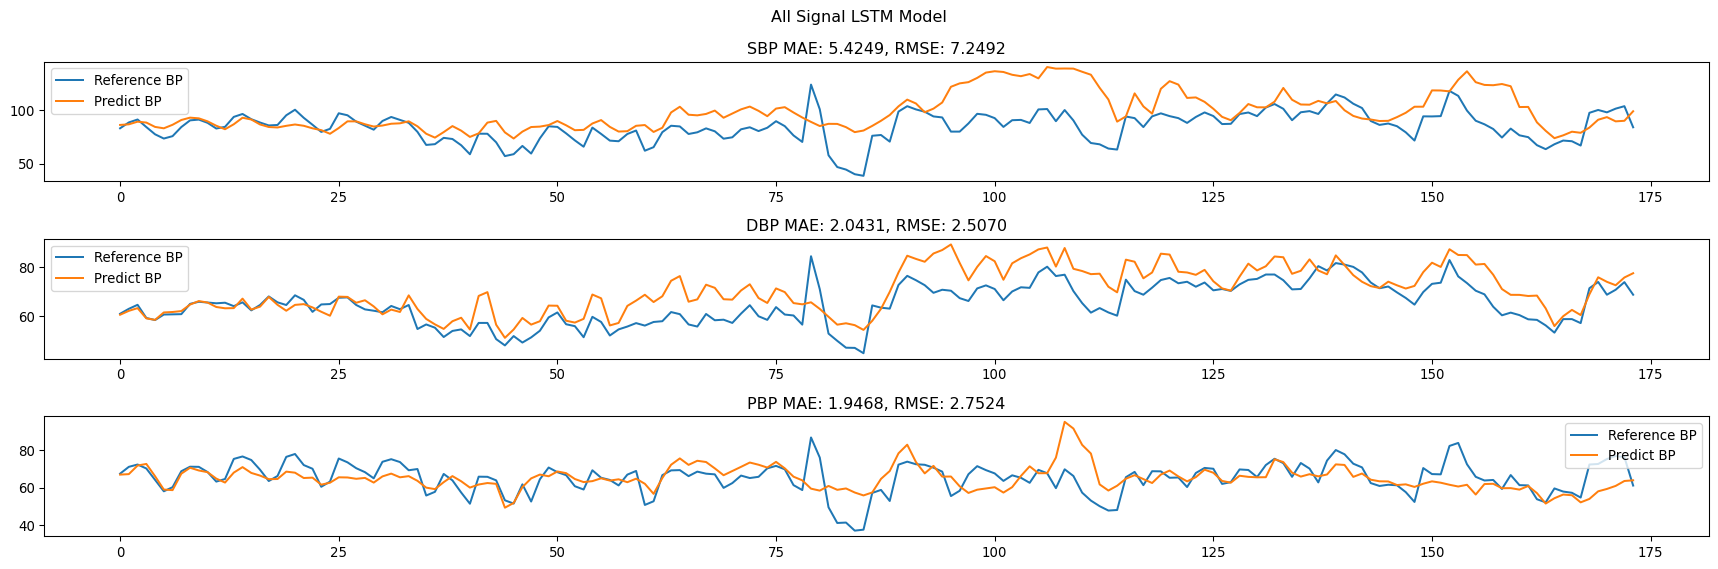

In [352]:
def bp_test_lstm():
    X_test, y_test = reshape_data(Nomft.iloc[split_site:])
    X_test = X_test.to(device)

    y_pred = {}
    y_pred['SBP'] = sbp_lstm_model(X_test)
    y_pred['DBP'] = dbp_lstm_model(X_test)
    y_pred['PBP'] = pbp_lstm_model(X_test)
    
    results = {}
    results['BP'] = ['SBP', 'DBP', 'PBP']
    results['ref_BP'] = [y_test['SBP'][:, -1] * (max_bp - min_bp) + min_bp, y_test['DBP'][:, -1] * (max_bp - min_bp) + min_bp, y_test['PBP'][:, -1] * (max_bp - min_bp)]
    results['pred_BP'] = [(y_pred['SBP'][:, -1] * (max_bp - min_bp) + min_bp).cpu(), (y_pred['DBP'][:, -1] * (max_bp - min_bp) + min_bp).cpu(), (y_pred['PBP'][:, -1] * (max_bp - min_bp)).cpu()]
    results['MAE'] = ["{:.4f}".format(torch.mean(torch.abs(results['ref_BP'][i] - results['pred_BP'][i])).item() / 3) for i in range(3)]
    results['RMSE'] = ["{:.4f}".format(torch.sqrt(torch.mean((results['ref_BP'][i] - results['pred_BP'][i]) ** 2)).item() / 3) for i in range(3)]

    ## Compare BPs
    #if float(results["MAE"][0]) <= 7 or float(results["MAE"][1])<=3:
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(18, 6), dpi=96)
    for i in range(3):
        axs[i].plot(results['ref_BP'][i], label='Reference BP')
        axs[i].plot(results['pred_BP'][i].cpu().detach().numpy(), label='Predict BP')
        axs[i].set_title(f'{results["BP"][i]} MAE: {results["MAE"][i]}, RMSE: {results["RMSE"][i]}')
        axs[i].legend()
    fig.suptitle(f"All Signal LSTM Model")
    plt.tight_layout()
    #plt.savefig(f'{result_path}/S1_LSTM_{layers}layers_{num_epochs}epochs.png', format='png')
    plt.show()
    return 

bp_test_lstm()

Show the results